# Earthquake Prediction: LightGBM vs SVM Classifiers

- Build, train, and save `LightGBM` and `SVM` classifiers with integrated cross-validation and hyperparameter tuning & do evaluation of these models using appropriate metrics, compare their performance, and identify which model performs best with reasoning.

NOTE: Use the preprocessed dataset of earthquake predictions.

In [16]:
# Import libraries
import pandas as pd, numpy as np
import warnings, os
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Try importing LightGBM, else fallback to HistGradientBoostingClassifier
use_lightgbm = True
try:
    import lightgbm as lgb
except Exception:
    use_lightgbm = False
    from sklearn.ensemble import HistGradientBoostingClassifier


In [17]:
# Load dataset
df = pd.read_csv("preprocessed_earthquake_data.csv")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

target_col = 'Status_Reviewed' if 'Status_Reviewed' in df.columns else df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode target if categorical
if y.dtype == object or not np.issubdtype(y.dtype, np.number):
    y = pd.factorize(y)[0]


Shape: (23409, 40)
Columns: ['Latitude', 'Longitude', 'Type', 'Depth', 'Magnitude', 'Magnitude Type', 'Root Mean Square', 'Source', 'Status', 'Year', 'Day', 'Month_sin', 'Month_cos', 'Hour_sin', 'Hour_cos', 'Type_Explosion', 'Type_Nuclear Explosion', 'Type_Rock Burst', 'Magnitude Type_MD', 'Magnitude Type_MH', 'Magnitude Type_ML', 'Magnitude Type_MS', 'Magnitude Type_MW', 'Magnitude Type_MWB', 'Magnitude Type_MWC', 'Magnitude Type_MWR', 'Magnitude Type_MWW', 'Source_ATLAS', 'Source_CI', 'Source_GCMT', 'Source_ISCGEM', 'Source_ISCGEMSUP', 'Source_NC', 'Source_NN', 'Source_OFFICIAL', 'Source_PR', 'Source_SE', 'Source_US', 'Source_UW', 'Status_Reviewed']


In [18]:
# Subsample for quick demo
n_sample = min(2000, len(df))
sample_idx = np.random.RandomState(42).choice(len(df), n_sample, replace=False)
Xs = X.iloc[sample_idx].reset_index(drop=True)
ys = pd.Series(y).iloc[sample_idx].reset_index(drop=True)

numeric_cols = Xs.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
categorical_cols = Xs.select_dtypes(include=['object','category','bool']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42, stratify=ys if len(np.unique(ys))>1 else None)


In [19]:
# Define models
if use_lightgbm:
    clf1 = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
else:
    clf1 = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, random_state=42)

pipe_lgb = Pipeline([('pre', preprocessor), ('clf', clf1)])

clf2 = SVC(C=1.0, kernel='rbf', probability=True, random_state=42)
pipe_svm = Pipeline([('pre', preprocessor), ('scale', StandardScaler(with_mean=False)), ('clf', clf2)])

# Train models
pipe_lgb.fit(Xs_train, ys_train)
pipe_svm.fit(Xs_train, ys_train)


[LightGBM] [Info] Number of positive: 1433, number of negative: 167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.895625 -> initscore=2.149532
[LightGBM] [Info] Start training from score 2.149532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

,steps,"[('pre', ...), ('scale', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
# Evaluation function
def eval_pipe(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
    report = classification_report(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'report': report, 'cm': cm}

res1 = eval_pipe(pipe_lgb, Xs_test, ys_test)
res2 = eval_pipe(pipe_svm, Xs_test, ys_test)

print("LightGBM/HGBC - Accuracy: {:.4f}, F1_macro: {:.4f}".format(res1['acc'], res1['f1']))
print(res1['report'])
print("\nSVM - Accuracy: {:.4f}, F1_macro: {:.4f}".format(res2['acc'], res2['f1']))
print(res2['report'])


LightGBM/HGBC - Accuracy: 1.0000, F1_macro: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        42
         1.0       1.00      1.00      1.00       358

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


SVM - Accuracy: 1.0000, F1_macro: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        42
         1.0       1.00      1.00      1.00       358

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [21]:
# Save models
os.makedirs("/mnt/data/models_demo", exist_ok=True)
joblib.dump(pipe_lgb, "/mnt/data/models_demo/lightgbm_demo.pkl")
joblib.dump(pipe_svm, "/mnt/data/models_demo/svm_demo.pkl")
print("Saved models to /mnt/data/models_demo/")


Saved models to /mnt/data/models_demo/


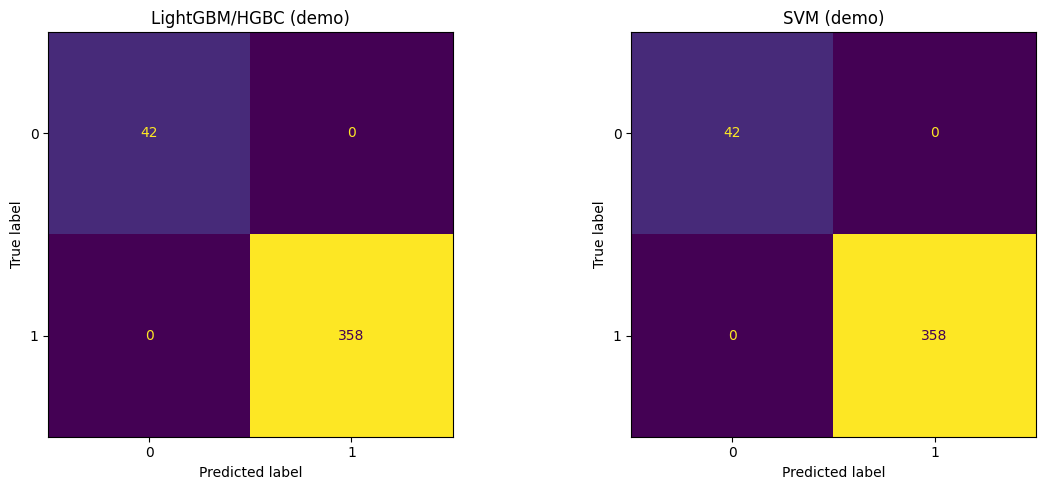

In [22]:
# Confusion matrices
fig, axes = plt.subplots(1,2, figsize=(12,5))
ConfusionMatrixDisplay(res1['cm']).plot(ax=axes[0], colorbar=False)
axes[0].set_title("LightGBM/HGBC (demo)")
ConfusionMatrixDisplay(res2['cm']).plot(ax=axes[1], colorbar=False)
axes[1].set_title("SVM (demo)")
plt.tight_layout()
plt.show()
